In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate
import numpy as np

import statsmodels as sm
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.vector_ar import plotting
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

%matplotlib inline

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [4]:
def tsplot(y, title, lags=None, figsize=(12, 6)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    plt.text(-6,-1.4, "Fig. 4.3", size=12, ha="center",weight='bold');
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax

Make sure the finalized data output is saved in Scenario3's folder

In [5]:
dataset = pd.read_csv('../Scenario3/data_merged_final.csv',index_col=0)

In [6]:
dataset.tail()

,Beer,Car,Steel,Gas,Electricity,Temp
Date,,,,,,
1991-11-01,192.0,23870.0,415.0,42145,12449,23.4
1991-12-01,192.0,16001.0,568.0,38698,12489,24.2
1992-01-01,147.0,11055.0,577.0,38963,12621,25.3
1992-02-01,133.0,21181.0,517.0,38690,12380,25.0
1992-03-01,163.0,25467.0,558.0,39792,13023,25.4


In [7]:
CsI=dataset['Beer']
WLS=dataset['Steel']

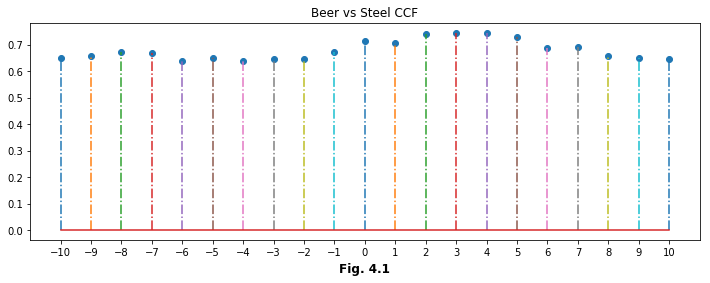

In [8]:
import scipy.signal as ss
import numpy as np
import matplotlib.pyplot as plt

maxlags = 10
result = result = ss.correlate(CsI - np.mean(CsI), WLS - np.mean(WLS), method='direct')/(np.std(CsI)*np.std(WLS)*len(CsI))
lo = (len(result)-1)//2-10 #just get +/- 10 elements around lag 0
hi = (len(result)-1)//2+11

locs = np.arange(lo, hi)
# for loc in locs:
#     print(str(loc)+'\t:\t'+str(result[loc]))

#Make a plot like ccf
f, ax = plt.subplots(figsize=(12,4))
ax.stem(np.arange(-10,11), result[lo:hi], '-.')
ax.set_xticks(np.arange(-10,11))
ax.text(0.5,-0.15, "Fig. 4.1", size=12, ha="center", transform=ax.transAxes,weight='bold')
ax.set_title('Beer vs Steel CCF')
plt.show()

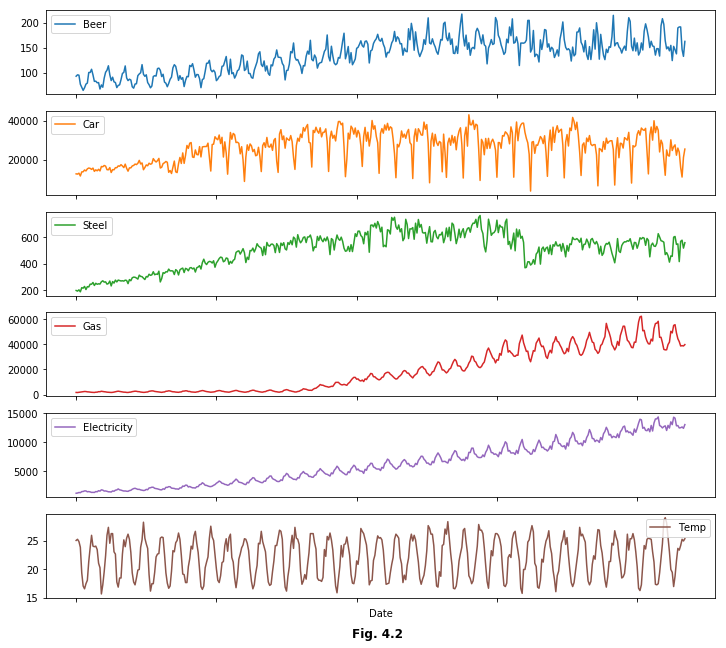

In [9]:
dataset.plot(subplots=True,figsize=(12,12))
plt.text(215,8, "Fig. 4.2", size=12, ha="center",weight='bold');

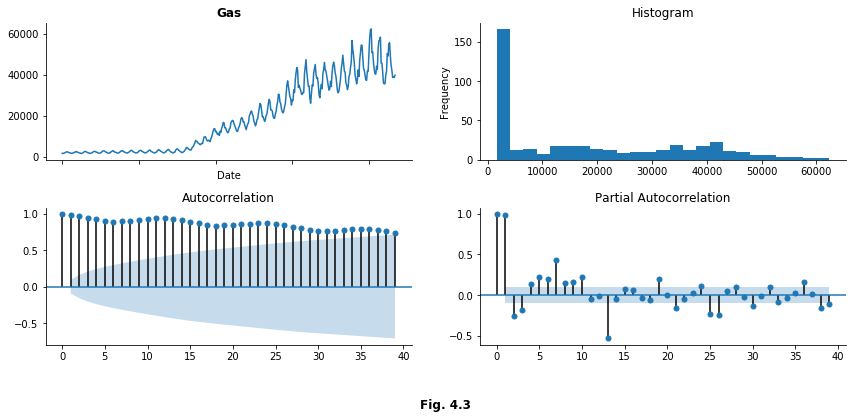

(<matplotlib.axes._subplots.AxesSubplot at 0x1c42b1bc88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x101e7d320>)

In [10]:
tsplot(dataset['Gas'],'Gas',lags=np.arange(0,40))

#### Stationarity Test

In [81]:
adf_test(dataset['Beer'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.007111
p-value                          0.283464
#Lags Used                      17.000000
Number of Observations Used    417.000000
Critical Value (1%)             -3.446129
Critical Value (5%)             -2.868496
Critical Value (10%)            -2.570475
dtype: float64


In [11]:
adf_test(dataset['Temp'])

Results of Dickey-Fuller Test:
Test Statistic                -6.333879e+00
p-value                        2.862096e-08
#Lags Used                     1.800000e+01
Number of Observations Used    4.160000e+02
Critical Value (1%)           -3.446168e+00
Critical Value (5%)           -2.868513e+00
Critical Value (10%)          -2.570484e+00
dtype: float64


For temperature, the test statistic < critical value, which implies that the series is stationary.

In [12]:
adf_test(dataset['Car'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.737860
p-value                          0.067713
#Lags Used                      13.000000
Number of Observations Used    421.000000
Critical Value (1%)             -3.445979
Critical Value (5%)             -2.868430
Critical Value (10%)            -2.570440
dtype: float64


For car, the test statistic < critical value in 10% significance level, which implies that the series is stationary. The cas has growth in the beginning but tends to stationay later.

In [13]:
adf_test(dataset['Steel'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.252618
p-value                          0.187705
#Lags Used                      12.000000
Number of Observations Used    422.000000
Critical Value (1%)             -3.445941
Critical Value (5%)             -2.868413
Critical Value (10%)            -2.570431
dtype: float64


In [14]:
adf_test(dataset['Gas'])

Results of Dickey-Fuller Test:
Test Statistic                   0.205778
p-value                          0.972584
#Lags Used                      17.000000
Number of Observations Used    417.000000
Critical Value (1%)             -3.446129
Critical Value (5%)             -2.868496
Critical Value (10%)            -2.570475
dtype: float64


In [15]:
adf_test(dataset['Electricity'])

Results of Dickey-Fuller Test:
Test Statistic                   1.563761
p-value                          0.997745
#Lags Used                      17.000000
Number of Observations Used    417.000000
Critical Value (1%)             -3.446129
Critical Value (5%)             -2.868496
Critical Value (10%)            -2.570475
dtype: float64


#### Transformation to stationary series for non-stationary series.

Use log transform for **steel**.

In [16]:
dataset['Steel_log'] = np.log(dataset['Steel'])
dataset['Steel_log_diff'] = dataset['Steel_log'] - dataset['Steel_log'].shift(1)
adfuller(dataset['Steel_log_diff'].dropna())

(-6.287739626234397,
 3.662730800933553e-08,
 13,
 420,
 {'1%': -3.4460159927788574,
  '5%': -2.868446209372638,
  '10%': -2.570448781179138},
 -897.0581197796027)

For **gas & electricity**, first seasonal difference. then difference by 1.

In [17]:
dataset['Gas_diff_seas'] = dataset['Gas'] - dataset['Gas'].shift(12)
dataset['Gas_diff'] = dataset['Gas_diff_seas'] - dataset['Gas_diff_seas'].shift(1)

In [18]:
adfuller(dataset['Gas_diff'].dropna())

(-7.4238058254419075,
 6.629388763873165e-11,
 18,
 403,
 {'1%': -3.4466811208382437,
  '5%': -2.8687386420385494,
  '10%': -2.5706046655665635},
 6970.282319837302)

In [19]:
dataset['Electricity_diff_seas'] = dataset['Electricity'] - dataset['Electricity'].shift(12)
dataset['Electricity_diff'] = dataset['Electricity_diff_seas'] - dataset['Electricity_diff_seas'].shift(1)

In [20]:
adfuller(dataset['Electricity_diff'].dropna())

(-6.32664313158626,
 2.97516703220987e-08,
 17,
 404,
 {'1%': -3.44664043608676,
  '5%': -2.868720756230461,
  '10%': -2.5705951311145965},
 5275.094116151984)

In [21]:
dataset_stationary=dataset.drop(['Steel','Gas','Electricity',\
                                 'Steel_log','Gas_diff_seas','Electricity_diff_seas'],axis=1).iloc[13:]

now we have got the stationary series

In [77]:
dataset_stationary.head()
#dataset_stationary.to_csv('dataset_stationary.csv',sep=',')

,Beer,Car,Temp,Steel_log_diff,Gas_diff,Electricity_diff
Date,,,,,,
1957-02-01,82.8,13985.911224,24.0,-0.092787,0.0,-58.0
1957-03-01,83.3,14767.651312,24.1,0.069590,84.0,67.0
1957-04-01,80.0,14270.452770,23.5,-0.030697,-63.0,-8.0
1957-05-01,80.4,15046.366905,21.1,0.014658,75.0,2.0
1957-06-01,67.5,14187.495032,20.3,-0.008525,-180.0,-97.0


#### Training by LSTM

In [23]:
values = dataset_stationary.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [24]:
# specify the number of lag hours
n_days = 24
n_features = 6

# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, n_days)

#reframed.to_csv('input_LSTM.csv')

In [25]:
# split into train and test sets
values = reframed.values
n_train_days = 330
train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [26]:
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:,n_obs::n_features]
test_X, test_y = test[:, :n_obs], test[:,n_obs::n_features]
print(train_X.shape, len(train_X), train_y.shape)

(330, 144) 330 (330, 24)


In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(330, 24, 6) (330, 24) (45, 24, 6) (45, 24)


In [28]:
train_X_all, train_y_all = values[:, :n_obs], values[:,n_obs::n_features]
train_X_all = train_X_all.reshape((train_X_all.shape[0], n_days, n_features))

In [29]:
train_X_all.shape,train_y_all.shape

((375, 24, 6), (375, 24))

In [30]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_days))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X_all, train_y_all, epochs=200, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 375 samples, validate on 45 samples
Epoch 1/200
 - 3s - loss: 0.2207 - val_loss: 0.1360
Epoch 2/200
 - 1s - loss: 0.1913 - val_loss: 0.1210
Epoch 3/200
 - 1s - loss: 0.1923 - val_loss: 0.1177
Epoch 4/200
 - 1s - loss: 0.1839 - val_loss: 0.1152
Epoch 5/200
 - 1s - loss: 0.1770 - val_loss: 0.1150
Epoch 6/200
 - 1s - loss: 0.1694 - val_loss: 0.1147
Epoch 7/200
 - 1s - loss: 0.1604 - val_loss: 0.1151
Epoch 8/200
 - 1s - loss: 0.1496 - val_loss: 0.1128
Epoch 9/200
 - 1s - loss: 0.1377 - val_loss: 0.1097
Epoch 10/200
 - 1s - loss: 0.1290 - val_loss: 0.1090
Epoch 11/200
 - 1s - loss: 0.1125 - val_loss: 0.1037
Epoch 12/200
 - 1s - loss: 0.1018 - val_loss: 0.0976
Epoch 13/200
 - 1s - loss: 0.0881 - val_loss: 0.0897
Epoch 14/200
 - 1s - loss: 0.1005 - val_loss: 0.0907
Epoch 15/200
 - 1s - loss: 0.0806 - val_loss: 0.0882
Epoch 16/200
 - 1s - loss: 0.0926 - val_loss: 0.0

Epoch 144/200
 - 1s - loss: 0.0559 - val_loss: 0.0620
Epoch 145/200
 - 1s - loss: 0.0592 - val_loss: 0.0585
Epoch 146/200
 - 1s - loss: 0.0600 - val_loss: 0.0596
Epoch 147/200
 - 1s - loss: 0.0573 - val_loss: 0.0594
Epoch 148/200
 - 1s - loss: 0.0551 - val_loss: 0.0605
Epoch 149/200
 - 1s - loss: 0.0591 - val_loss: 0.0583
Epoch 150/200
 - 1s - loss: 0.0608 - val_loss: 0.0593
Epoch 151/200
 - 1s - loss: 0.0568 - val_loss: 0.0590
Epoch 152/200
 - 1s - loss: 0.0550 - val_loss: 0.0597
Epoch 153/200
 - 1s - loss: 0.0583 - val_loss: 0.0582
Epoch 154/200
 - 1s - loss: 0.0601 - val_loss: 0.0590
Epoch 155/200
 - 1s - loss: 0.0556 - val_loss: 0.0588
Epoch 156/200
 - 1s - loss: 0.0550 - val_loss: 0.0593
Epoch 157/200
 - 1s - loss: 0.0578 - val_loss: 0.0593
Epoch 158/200
 - 1s - loss: 0.0602 - val_loss: 0.0591
Epoch 159/200
 - 1s - loss: 0.0552 - val_loss: 0.0590
Epoch 160/200
 - 1s - loss: 0.0549 - val_loss: 0.0589
Epoch 161/200
 - 1s - loss: 0.0566 - val_loss: 0.0597
Epoch 162/200
 - 1s - loss: 

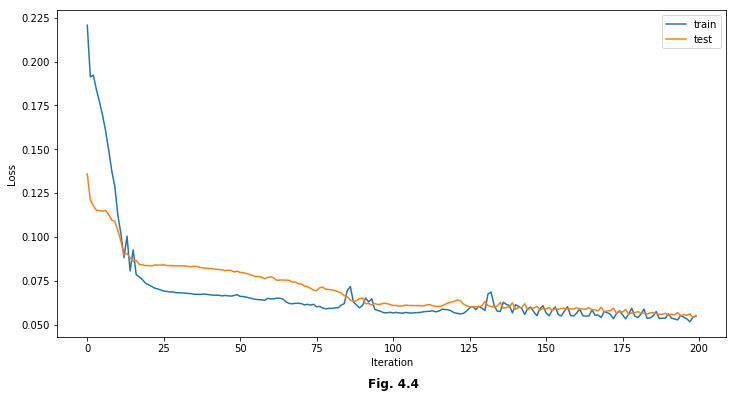

In [62]:
# plot history
fig=plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.text(100,0.014, "Fig. 4.4", size=12, ha="center",weight='bold')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

In [63]:
test_y[-1:]

array([[0.57351963, 0.56819694, 0.45242848, 0.53892216, 0.53825682,
        0.43978709, 0.84231537, 0.93878909, 0.86360612, 0.64471058,
        0.53626081, 0.56220892, 0.50964737, 0.582169  , 0.37924152,
        0.56886228, 0.52228876, 0.46906188, 0.81503659, 0.82834331,
        0.82834331, 0.52894212, 0.43579508, 0.63539587]])

In [64]:
yhat=model.predict(test_X[-1:])
test_X_res = test_X.reshape((test_X.shape[0], n_days*n_features))

# invert scaling for forecast

yhat_last24=[]
ytrue_last24=[]

for i in np.arange(n_days):
    inv_yhat = concatenate((yhat[-1:,[i]], test_X_res[-1:, -5:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    yhat_last24.append(inv_yhat)

for i in np.arange(n_days):
    inv_y = concatenate((test_y[-1:,[i]], test_X_res[-1:, -5:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    ytrue_last24.append(inv_y)

In [65]:
yhat=model.predict(np.reshape(test[-1,n_obs:],newshape=(1,n_days,n_features)))
test_X_res = test_X.reshape((test_X.shape[0], n_days*n_features))

# invert scaling for forecast

yhat_future=[]

for i in np.arange(n_days):
    inv_yhat = concatenate((yhat[-1:,[i]], test_X_res[-1:, -5:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    yhat_future.append(inv_yhat)

In [66]:
yhat_future

[array([153.17626657]),
 array([147.75280609]),
 array([139.05025966]),
 array([144.73785934]),
 array([153.00961014]),
 array([160.74289665]),
 array([171.59951974]),
 array([194.07880499]),
 array([194.21545018]),
 array([161.36012476]),
 array([153.74691008]),
 array([166.93110614]),
 array([148.62465491]),
 array([148.46581932]),
 array([135.17868919]),
 array([144.65201824]),
 array([148.88629915]),
 array([153.30199125]),
 array([172.02154044]),
 array([192.2282763]),
 array([191.393731]),
 array([158.31795289]),
 array([152.38526891]),
 array([157.42630561])]

In [67]:
test_X.shape,yhat.shape,test_X_res.shape,test_y.shape

((45, 24, 6), (1, 24), (45, 144), (45, 24))

In [68]:
#np.savetxt('../Result in CSV/Li_Scenario4.csv', yhat_future, delimiter=',')

### Prediction Interval using simple univariate ARMA Model

In [12]:
import csv
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [13]:
Beer=pd.read_csv('../Scenario3/data_merged_final.csv',sep=',',index_col=0,usecols=[0,1])

In [14]:
mod = sm.tsa.statespace.SARIMAX(Beer,
                                order=(1, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False,)

results = mod.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                   Beer   No. Observations:                  435
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1872.418
Date:                Tue, 23 Apr 2019   AIC                           3750.837
Time:                        20:57:46   BIC                           3763.049
Sample:                    01-01-1956   HQIC                          3755.658
                         - 03-01-1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9968      0.004    237.065      0.000       0.989       1.005
ma.L1         -0.3107      0.044     -7.066      0.000      -0.397      -0.225
sigma2       335.4263     21.510     15.594      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [15]:
# Get forecast 24 steps ahead in future
pred_uc = results.get_forecast(steps=24)

# Get 95% confidence intervals of forecasts
pred_ci = pred_uc.conf_int(alpha=0.05)

In [16]:
s=pd.DataFrame(pred_uc.predicted_mean)
s.columns=['Beer']
s.set_index(s.columns[0])
s.index.name='Date'
s.index=s.index.to_period('D')

In [17]:
Beer.index = pd.to_datetime(Beer.index)
Beer.index=Beer.index.to_period('D')

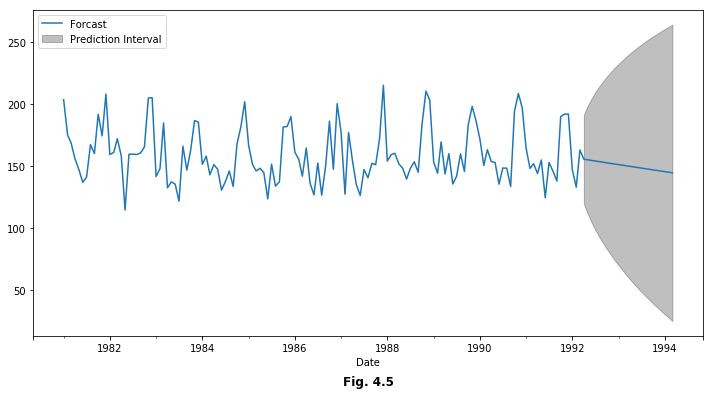

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
Beer.append(s)[300:].plot(ax=ax)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.text(0.5,-0.15, "Fig. 4.5", size=12, ha="center", transform=ax.transAxes,weight='bold')
plt.legend(['Forcast','Prediction Interval'],loc=2)
plt.show()

### Prediction Interval using simple vector AR model

In [21]:
dataset=pd.read_csv('dataset_stationary.csv',sep=',',index_col=0)

In [22]:
initial=dataset['Beer'][0]
end=dataset['Beer'][-1]

In [23]:
adf_test(dataset['Beer'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.973067
p-value                          0.298506
#Lags Used                      17.000000
Number of Observations Used    404.000000
Critical Value (1%)             -3.446640
Critical Value (5%)             -2.868721
Critical Value (10%)            -2.570595
dtype: float64


In [24]:
model = VAR(dataset)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [25]:
results = model.fit()
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, Apr, 2019
Time:                     20:59:09
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    44.7285
Nobs:                     421.000    HQIC:                   44.4845
Log likelihood:          -12872.7    FPE:                1.77902e+19
AIC:                      44.3252    Det(Omega_mle):     1.61143e+19
--------------------------------------------------------------------
Results for equation Beer
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      24.919009         7.722018            3.227           0.001
L1.Beer                     0.815589         0.031621           25.793           0.000
L1.Car                      0.000500 

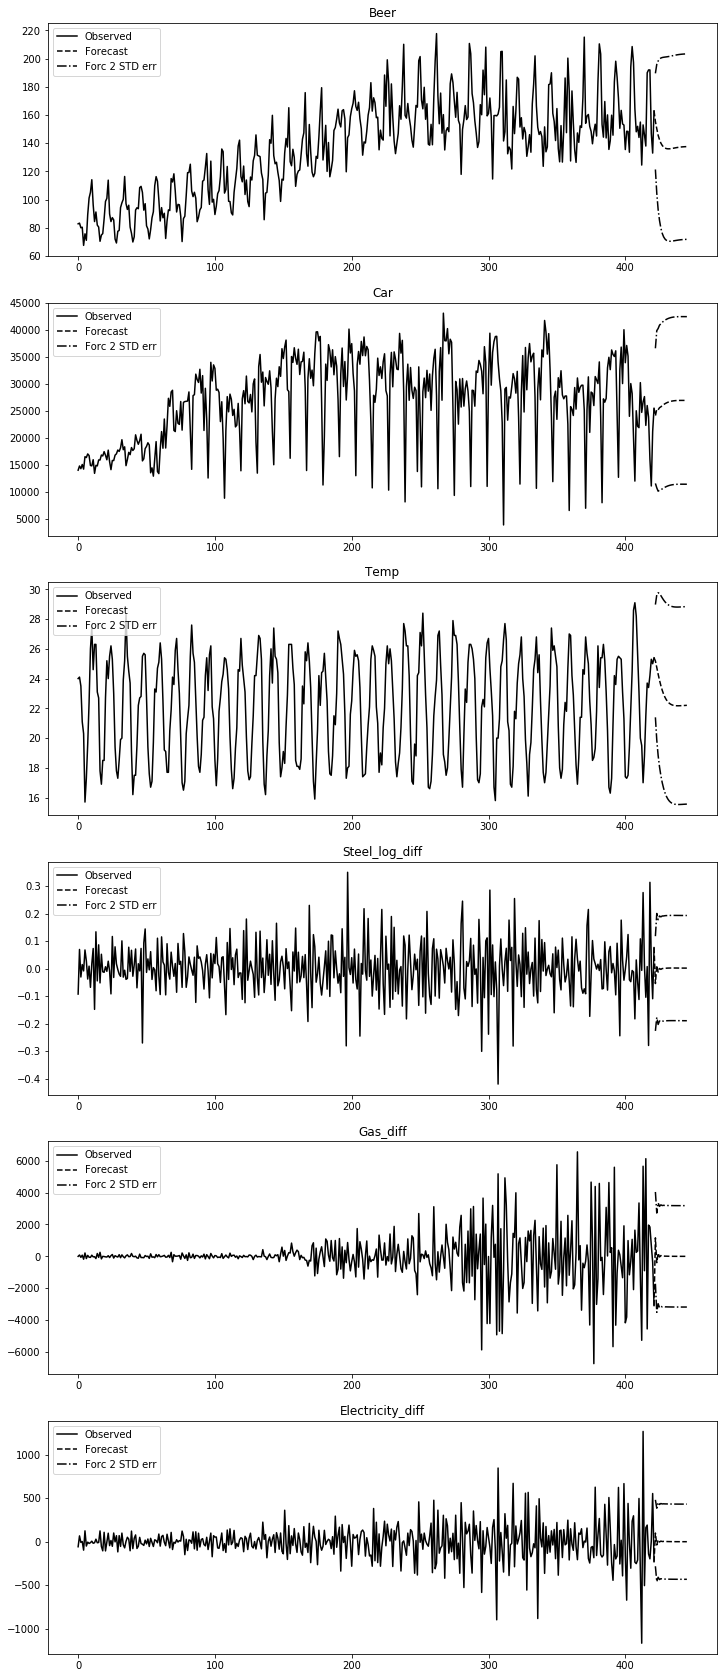

In [27]:
mid, lower, upper = results.forecast_interval(results.y[-results.k_ar:], steps=24,
                                           alpha=0.05)
fig = plotting.plot_var_forc(results.y, mid, lower, upper,
                             names=results.names, plot_stderr=True,fig=plt.figure(figsize=(12,30)))